In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow requirements
import tensorboard as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import img_to_array, load_img

import os
from bs4 import BeautifulSoup

In [3]:
img_folder = 'images/'
annot_folder = 'annotations/'

In [4]:
desc = []
for dirname, _, files in os.walk(annot_folder):
    for filename in files:
        desc.append(os.path.join(dirname, filename))

In [5]:
img_name,label = [],[]

for d in desc:
    content = []
    n = []

    with open(d, "r") as file:
        content = file.readlines()
    content = "".join(content)
    soup = BeautifulSoup(content,"html.parser")
    file_name = soup.filename.string
    name_tags = soup.find_all("name")
    

    for t in name_tags:
        n.append(t.get_text())
        
    # selecting tag with maximum occurence in an image (If it has multiple tags)
    name = max(set(n), key = n.count)
  
    img_name.append(file_name)
    label.append(name)

In [6]:
# One-hot encoding
labels = pd.get_dummies(label)
labels.head()

,mask_weared_incorrect,with_mask,without_mask
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [7]:
# Target classes
classes = list(labels.columns)
print(classes)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [8]:
data, target = [], []
imh_h = img_w = 256
for i in range(0, len(img_name)):
    name = img_name[i]
    path = img_folder + name

    img = load_img(path, target_size=(imh_h, img_w))
    img = img_to_array(img)
    data.append(img)
    target.append(tuple(labels.iloc[i, :]))

In [9]:
# Convert list to numpy array
data = np.array(data) / 255.0
target = np.array(target)

In [10]:
type(data), type(target)

(numpy.ndarray, numpy.ndarray)

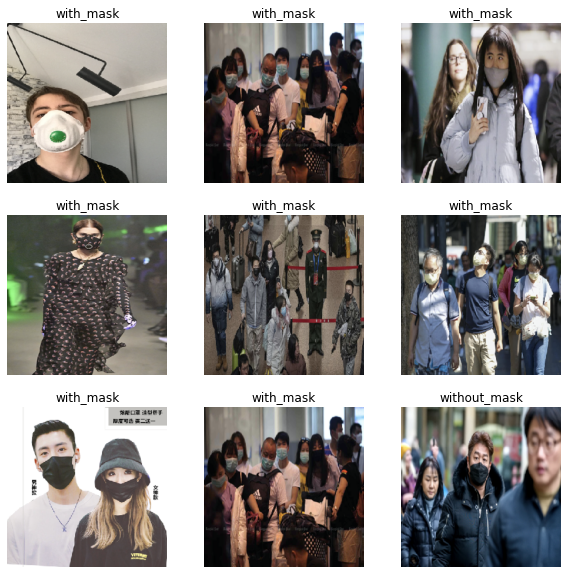

In [11]:
# Plot some random data
plt.figure(figsize=(10, 10))
for i,j in enumerate(np.random.randint(1, 500, 9, dtype=int)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[j])
    plt.title(label[j])
    plt.axis("off")

In [12]:
data.shape, target.shape

((853, 256, 256, 3), (853, 3))

In [13]:
# Split into training and test sets
train_img, test_img, train_labels, test_labels = train_test_split(data, target, test_size=0.2)

In [14]:
print('Training shape:', train_img.shape, train_labels.shape)
print('Testing  shape:', test_img.shape, test_labels.shape)

Training shape: (682, 256, 256, 3) (682, 3)
Testing  shape: (171, 256, 256, 3) (171, 3)


## Fitting the model

In [17]:
num_classes = 3
model = Sequential([
    layers.Conv2D(16, 3, padding="same", input_shape=(imh_h, img_w, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)            

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Fit the model
epochs = 15
model.fit(train_img, train_labels, epochs=epochs, validation_data=(test_img, test_labels), batch_size=16)

Epoch 1/15
43/43 [==============================] - 29s 677ms/step - loss: 1.9958 - accuracy: 0.6994 - val_loss: 0.7975 - val_accuracy: 0.7661
Epoch 2/15
43/43 [==============================] - 26s 604ms/step - loss: 0.7422 - accuracy: 0.7522 - val_loss: 0.5752 - val_accuracy: 0.8304
Epoch 3/15
43/43 [==============================] - 23s 542ms/step - loss: 0.4194 - accuracy: 0.8490 - val_loss: 0.5644 - val_accuracy: 0.8304
Epoch 4/15
43/43 [==============================] - 22s 523ms/step - loss: 0.3247 - accuracy: 0.8754 - val_loss: 0.6174 - val_accuracy: 0.8129
Epoch 5/15
43/43 [==============================] - 25s 571ms/step - loss: 0.2112 - accuracy: 0.9457 - val_loss: 0.6070 - val_accuracy: 0.8363
Epoch 6/15
43/43 [==============================] - 23s 531ms/step - loss: 0.1655 - accuracy: 0.9501 - val_loss: 0.5804 - val_accuracy: 0.8129
Epoch 7/15
43/43 [==============================] - 23s 528ms/step - loss: 0.1036 - accuracy: 0.9765 - val_loss: 0.6312 - val_accuracy: 0.8421

Model is clearly overfitting

## Data Augmentation

In [18]:
# Data Augmentation Layer
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(imh_h, img_w, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [19]:
model_new = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding="same", input_shape=(imh_h, img_w, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

In [20]:
model_new.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [21]:
model_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)       

In [22]:
# Fit the model
epochs = 20
history = model_new.fit(train_img, train_labels, epochs=epochs, validation_data=(test_img, test_labels), batch_size=16)

Epoch 1/20
43/43 [==============================] - 32s 737ms/step - loss: 0.8539 - accuracy: 0.8065 - val_loss: 0.5253 - val_accuracy: 0.8421
Epoch 2/20
43/43 [==============================] - 31s 723ms/step - loss: 0.5213 - accuracy: 0.8578 - val_loss: 0.5618 - val_accuracy: 0.8421
Epoch 3/20
43/43 [==============================] - 33s 774ms/step - loss: 0.4960 - accuracy: 0.8578 - val_loss: 0.4860 - val_accuracy: 0.8421
Epoch 4/20
43/43 [==============================] - 28s 649ms/step - loss: 0.4661 - accuracy: 0.8578 - val_loss: 0.5342 - val_accuracy: 0.8421
Epoch 5/20
43/43 [==============================] - 28s 648ms/step - loss: 0.4675 - accuracy: 0.8592 - val_loss: 0.4601 - val_accuracy: 0.8538
Epoch 6/20
43/43 [==============================] - 28s 646ms/step - loss: 0.4593 - accuracy: 0.8592 - val_loss: 0.4785 - val_accuracy: 0.8421
Epoch 7/20
43/43 [==============================] - 28s 647ms/step - loss: 0.4401 - accuracy: 0.8622 - val_loss: 0.4449 - val_accuracy: 0.8538

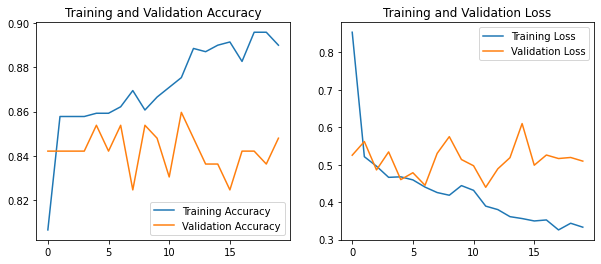

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing predictions

Predicted value ----  with_mask


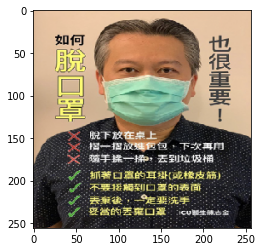

In [24]:
img = test_img[2].reshape(-1, imh_h, img_w, 3)
pred = classes[np.argmax(model_new.predict(img))]
plt.imshow(test_img[2])
print('Predicted value ---- ', pred)

In [26]:
## Save the model
model_new.save('keras_model.h5')